In [1]:
import torch

# CUDAが使えるかどうかを確認
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
     

CUDA is available! GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device Count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name()}")

PyTorch Version: 2.5.0+cu124
CUDA Available: True
CUDA Device Count: 1
Current CUDA Device: 0
Device Name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


# **1枚画像**


image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L.jpg: 640x640 1 Eyelid, 1 Caruncle, 58.8ms
Speed: 4.0ms preprocess, 58.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)
0 0.535489 0.501070 0.556423 0.219244
1 0.233409 0.509880 0.114327 0.054559


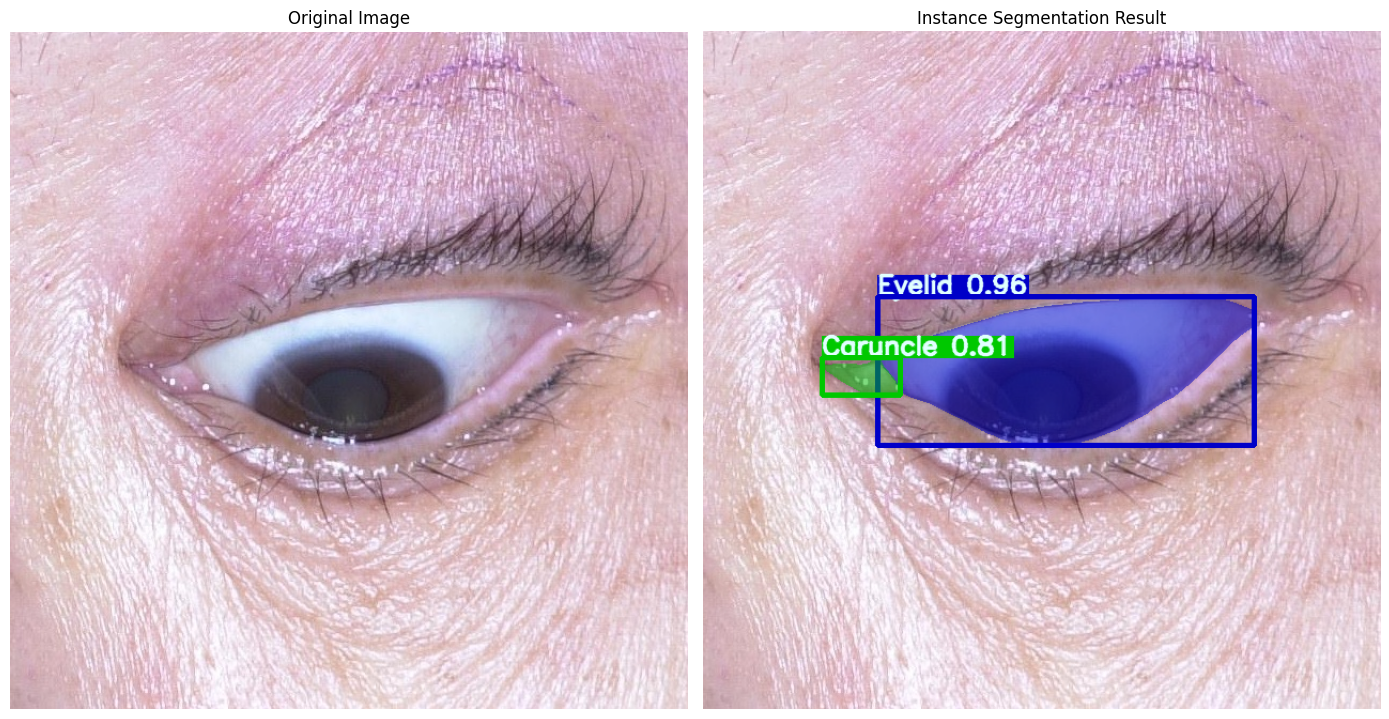

In [4]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = YOLO(r"C:\Users\CorneAI\YOLOv11_Mobius\models\eyelid_racuncle_yolo11seg_1-139rotate.pt")
# model = RTDETR(r"C:\Users\CorneAI\FacePhoto_instance\models\1-295_538epochs_rtdetr-l.pt")

# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]
linewidth = 3
fontScale = 0.8
fontFace = cv2.FONT_HERSHEY_SIMPLEX
thickness = 2

# Mask overlay function
def overlay(image, mask, color, alpha):
    """Overlay segmentation mask on the image"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    image_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    return image_combined

# Bounding box and label drawing function
def draw_label(box, img, color, label, line_thickness=3):
    """Draw bounding box and label on the image"""
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    # Draw label background
    text_size = cv2.getTextSize(
        label, fontFace, fontScale=fontScale, thickness=line_thickness
    )[0]
    cv2.rectangle(
        img, (x1, y1), (x1 + text_size[0], y1 - text_size[1] - 2), color, -1
    )  # fill
    
    # Draw label text
    cv2.putText(
        img,
        label,
        (x1, y1 - 3),
        fontFace,
        fontScale,
        [225, 255, 255],
        thickness=line_thickness,
        lineType=cv2.LINE_AA,
    )

    # Draw bounding box
    cv2.rectangle(
        img,
        (x1, y1),
        (x2, y2),
        color,
        linewidth,
    )

# Main processing function
def main():
    # Image path for inference
    image_path = r'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L.jpg'
    
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    h, w, _ = image.shape
    
    # Run inference with the model
    results = model(image_path, conf=0.25, iou=0.45, retina_masks=True)
    result = results[0]
    
    # Create result image (copy of original)
    output_image = image_rgb.copy()
    
    # Process if masks are available
    if result.masks is not None:
        # Confidence scores list
        conf_list = result.boxes.conf.tolist()
        
        # Process each instance
        for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
            # Resize mask to match image dimensions
            mask = cv2.resize(mask, (w, h))
            
            # Get class ID
            class_id = int(box[5]) if box.shape[0] > 5 else 0
            
            # Select color (cycle through colors if class_id exceeds color list length)
            color_idx = class_id % len(colors)
            
            # Overlay mask with semi-transparency (alpha=0.5)
            output_image = overlay(output_image, mask, colors[color_idx], 0.5)
            
            # Bounding box information
            bbox = box[:4]
            
            # Get class name
            class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
            
            # Get confidence score
            score = box[4] if box.shape[0] > 4 else conf_list[i]
            
            # Create label text
            label_text = f"{class_name} {score:.2f}"
            
            # Draw bounding box and label
            draw_label(bbox, output_image, colors[color_idx], label_text, line_thickness=2)
            
            # Output in YOLO format
            x_center = (bbox[0] + bbox[2]) / (2 * w)
            y_center = (bbox[1] + bbox[3]) / (2 * h)
            width = (bbox[2] - bbox[0]) / w
            height = (bbox[3] - bbox[1]) / h
            print(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Display results
        plt.figure(figsize=(14, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image_rgb)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title("Instance Segmentation Result")
        plt.imshow(output_image)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Save results (optional)
        # output_filename = "segmentation_result.jpg"
        # cv2.imwrite(output_filename, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
        # print(f"Saved: {output_filename}")
    else:
        print("No segmentation masks found.")
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# Execute
if __name__ == "__main__":
    main()

# **複数画像**

階層構造
```
archive.zip/
   ├── data.yaml  # configuration file
   ├── train.txt  # list of train subset image paths
   │
   ├── images/
   │   ├── train/  # directory with images for train subset
   │   │    ├── image1.jpg
   │   │    ├── image2.jpg
   │   │    ├── image3.jpg
   │   │    └── ...
   ├── labels/
   │   ├── train/  # directory with annotations for train subset
   │   │    ├── image1.txt
   │   │    ├── image2.txt
   │   │    ├── image3.txt
   │   │    └── ...

```

***.txt (ラベル)
```
0 0.260745 0.535950 0.218015 0.030600......
```

daya.yaml
```
names:
  0: eyelid
path: .
train: train.txt
```

train.txt
```
data/images/train/***.jpg
data/images/train/***.jpg
...(pathの羅列。拡張子を合わせる)
```
※ラベルや画像と対応を合わせること



### Eyelid

In [3]:
from ultralytics import YOLO
import numpy as np
import cv2
import os
import glob
import zipfile
import shutil
import random
import matplotlib.pyplot as plt
# from scipy.interpolate import splprep, splev # Removed as smoothing is handled by retina_masks=True
import time
from concurrent.futures import ThreadPoolExecutor

"""
YOLOセグメンテーションデータセット生成ツール（高速化版）

機能:
- YOLOモデル推論結果からセグメンテーションデータセット自動生成 (retina_masks=True でのスムージングを推奨)
- 検出輪郭から均等に指定数の点（デフォルト100点）を配置
- YOLOフォーマットのラベル・データセット構造生成
- オプションで可視化結果も出力
- 並列処理による高速化（ファイルコピーと後処理のみ並列化）
"""

# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]

def distribute_points_evenly(polygon, num_points=100):
    """
    Redistribute points evenly along a polygon contour
    
    Args:
        polygon: Numpy array of polygon points with shape (n, 2)
        num_points: Number of points to generate along the contour
    
    Returns:
        New polygon with evenly distributed points as numpy array with shape (num_points, 2)
    """
    # Make sure we have a numpy array
    polygon = np.array(polygon).reshape(-1, 2)
    
    # If the polygon doesn't have enough points, return it as is
    if len(polygon) < 3:
        return polygon
    
    # Calculate total perimeter length
    perimeter = 0
    for i in range(len(polygon)):
        next_idx = (i + 1) % len(polygon)
        perimeter += np.linalg.norm(polygon[next_idx] - polygon[i])
    
    # If perimeter is too small, return original polygon
    if perimeter < 1:
        return polygon
    
    # Distance between each new point
    segment_length = perimeter / num_points
    
    # Create new array for evenly distributed points
    new_points = np.zeros((num_points, 2), dtype=np.int32)
    
    # Initialize variables
    current_point = polygon[0].copy()
    new_points[0] = current_point
    polygon_idx = 0
    remaining_segment_length = segment_length
    
    # Create evenly spaced points
    for i in range(1, num_points):
        # Continue adding points until we've placed all required points
        while True:
            # Get current and next point on original polygon
            current = polygon[polygon_idx]
            next_idx = (polygon_idx + 1) % len(polygon)
            next_point = polygon[next_idx]
            
            # Calculate vector and length to next point
            vector = next_point - current
            segment_distance = np.linalg.norm(vector)
            
            # If we can fit the next point within current segment
            if segment_distance >= remaining_segment_length:
                # Calculate position of new point
                direction = vector / segment_distance
                current_point = current + direction * remaining_segment_length
                new_points[i] = np.round(current_point).astype(np.int32)
                # Reset remaining length for next iteration
                remaining_segment_length = segment_length
                break
            else:
                # Move to next segment
                polygon_idx = (polygon_idx + 1) % len(polygon)
                remaining_segment_length -= segment_distance
    
    return new_points

def process_contours_with_direct_inference(mask_binary, num_contour_points=100):
    """
    直接推論マスクから輪郭を抽出し、均等に点を配置する
    (YOLO推論時に retina_masks=True を使用することでスムージングされたマスクが得られる前提)
    
    Args:
        mask_binary: バイナリマスク (np.uint8)
        num_contour_points: 輪郭に沿って生成する点の数
    
    Returns:
        均等に配置された点を持つ輪郭 (np.array)
    """
    # 輪郭を見つける
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        return None
    
    # 最大の輪郭を取得
    largest_contour = max(contours, key=cv2.contourArea)
    
    # [n, 2]形式に整形
    contour_points = largest_contour.reshape(-1, 2)
    
    # スムージング処理は retina_masks=True で行われるため、ここでは不要
    
    # 輪郭に沿って点を均等に分布
    evenly_distributed_points = distribute_points_evenly(contour_points, num_contour_points)
    
    return evenly_distributed_points

def overlay_mask(image, mask, color, alpha=0.5):
    """Overlay mask on image with transparency"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    mask_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)
    return image_combined

def copy_image_parallel(src_path, dest_path):
    """画像をコピーする並列タスク"""
    shutil.copy2(src_path, dest_path)
    return dest_path

def create_yolo_segmentation_dataset(orig_image_dir, output_dir, model_path, yaml_content, num_images=None, random_selection=False, visualize_test=False, num_contour_points=100, max_points=None):
    """
    Create YOLO dataset structure for segmentation.
    Smoothing is expected to be handled by YOLO's `retina_masks=True` during inference.
    
    Args:
        orig_image_dir: Directory containing original images
        output_dir: Output directory for the dataset
        model_path: Path to the YOLO model
        yaml_content: Content for data.yaml file
        num_images: Number of images to process (None for all images)
        random_selection: Whether to randomly select images (if num_images is specified)
        visualize_test: Whether to visualize reconstructed masks (for test mode)
        num_contour_points: Number of points to generate along each contour (equally distributed)
        max_points: Maximum number of points to keep per contour (None for no limit)
    """
    start_time = time.time()
    total_steps = 5 if visualize_test else 4
    
    # ステップ1: ディレクトリ作成
    print(f"Creating dataset: Step 1/{total_steps}")
    os.makedirs(os.path.join(output_dir, "labels", "Train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images", "Train"), exist_ok=True)
    if visualize_test:
        os.makedirs(os.path.join(output_dir, "visualization"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "inference"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "labels"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "comparison"), exist_ok=True)
    
    # ステップ2: YAML作成
    print(f"Creating dataset: Step 2/{total_steps}")
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    
    # 画像ファイルを取得
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\nFound {total_files} files")
    
    # 必要なら画像を選択
    if num_images is not None and num_images < total_files:
        if random_selection:
            image_files = random.sample(image_files, num_images)
            print(f"Randomly selected {num_images} images for processing")
        else:
            image_files = image_files[:num_images]
            print(f"Selected first {num_images} images for processing")
        total_files = len(image_files)
    
    # ステップ3: 推論とラベル生成
    print(f"Creating dataset: Step 3/{total_steps}")
    print("\nInference and label generation")
    
    # モデルの読み込み（環境情報表示を抑制）
    model = YOLO(model_path, verbose=False)
    
    # オリジナル画像をコピー（並列処理）
    with ThreadPoolExecutor(max_workers=min(os.cpu_count(), 16)) as executor:
        # 画像のコピーを並列で実行
        src_dest_pairs = []
        for image_path in image_files:
            basename = os.path.basename(image_path)
            dest_path = os.path.join(output_dir, "images", "Train", basename)
            src_dest_pairs.append((image_path, dest_path))
        
        # 並列でコピー実行
        executor.map(lambda p: copy_image_parallel(*p), src_dest_pairs)
    
    # 処理ファイル情報を記録
    processed_files = []
    train_txt_paths = []
    
    # 順番に処理（モデル推論は並列化しない）
    for i, image_path in enumerate(image_files):
        # ファイル名を取得
        basename = os.path.basename(image_path)
        name_without_ext = os.path.splitext(basename)[0]
        
        # コピー先のファイルパス
        dest_image_path = os.path.join(output_dir, "images", "Train", basename)
        
        # ラベルファイルパス
        label_path = os.path.join(output_dir, "labels", "Train", f"{name_without_ext}.txt")
        
        # 画像読み込み
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image {image_path}")
            continue
        
        h, w = img.shape[:2]
        
        # モデル推論 (verbose=Falseで情報表示を抑制, retina_masks=Trueで高品質マスク)
        results = model(image_path, verbose=False, retina_masks=True)
        result = results[0]
        
        # テストモードでの可視化
        if visualize_test and hasattr(result, 'masks') and result.masks is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            inference_vis = img_rgb.copy()
            
            for i_mask, (mask_data, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())): # Renamed 'i' to 'i_mask' to avoid conflict
                class_id = int(box[5]) if box.shape[0] > 5 else 0
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                resized_mask = cv2.resize(mask_data, (w, h))
                mask_binary = (resized_mask > 0.5).astype(np.uint8)
                
                inference_vis = overlay_mask(inference_vis, mask_binary, color)
                
                x1, y1, x2, y2 = map(int, box[:4])
                cv2.rectangle(inference_vis, (x1, y1), (x2, y2), color, 2)
                
                conf = float(box[4])
                class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
                label = f"{class_name} {conf:.2f}"
                cv2.putText(inference_vis, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            cv2.imwrite(inference_vis_path, cv2.cvtColor(inference_vis, cv2.COLOR_RGB2BGR))
        
        # YOLOフォーマットでラベル作成
        with open(label_path, 'w', encoding='utf-8') as lf:
            if hasattr(result, 'masks') and result.masks is not None:
                for j, (mask_data, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())): # Renamed 'mask' to 'mask_data'
                    class_id = int(box[5]) if box.shape[0] > 5 else 0
                    
                    mask_resized = cv2.resize(mask_data, (w, h)) # Renamed 'mask' to 'mask_resized'
                    mask_binary = (mask_resized > 0.5).astype(np.uint8)
                    
                    distributed_points = process_contours_with_direct_inference(
                        mask_binary, 
                        num_contour_points=num_contour_points
                    )
                    
                    if distributed_points is not None and len(distributed_points) > 0:
                        polygon_points = []
                        for point in distributed_points:
                            x_norm = point[0] / w
                            y_norm = point[1] / h
                            polygon_points.extend([x_norm, y_norm])
                        
                        line = f"{class_id} " + " ".join([f"{p:.6f}" for p in polygon_points])
                        lf.write(line + "\n")
        
        # YOLO形式でパスを保存
        yolo_path = f"data/images/Train/{basename}"
        train_txt_paths.append(yolo_path)
        
        # 処理情報を記録
        processed_files.append({
            'image_path': dest_image_path,
            'label_path': label_path,
            'basename': basename,
            'name_without_ext': name_without_ext
        })
        
        # 進捗表示
        if (i+1) % 20 == 0 or (i+1) == total_files:
            print(f"Processed {i+1}/{total_files} images")
    
    # Train.txtを作成
    with open(os.path.join(output_dir, "Train.txt"), 'w', encoding='utf-8') as f:
        for path in train_txt_paths:
            f.write(f"{path}\n")
    
    # ステップ4: 可視化（テストモードのみ）
    if visualize_test and processed_files:
        print(f"Creating dataset: Step 4/{total_steps}")
        print("\nVisualizing reconstructed masks from labels...")
        
        for i, file_info in enumerate(processed_files):
            # 画像とラベルのパス
            image_path = file_info['image_path']
            label_path = file_info['label_path']
            
            # 画像読み込み
            image = cv2.imread(image_path)
            if image is None:
                continue
                
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape
            
            # 結果画像
            label_mask_image = image_rgb.copy()
            
            # ラベル読み込み
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # 各ラベル処理
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:  # class_id + 2 points (4 coordinates) minimum
                    continue
                    
                class_id = int(parts[0])
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                polygon_points = []
                for j in range(1, len(parts), 2):
                    if j+1 < len(parts):
                        x_norm = float(parts[j])
                        y_norm = float(parts[j+1])
                        x = int(x_norm * w)
                        y = int(y_norm * h)
                        polygon_points.append([x, y])
                
                polygon_points = np.array(polygon_points, dtype=np.int32)
                
                mask_from_label = np.zeros((h, w), dtype=np.uint8) # Renamed 'mask' to 'mask_from_label'
                cv2.fillPoly(mask_from_label, [polygon_points], 1)
                
                label_mask_image = overlay_mask(label_mask_image, mask_from_label, color)
                cv2.polylines(label_mask_image, [polygon_points], True, color, 2)
            
            # ラベルマスク可視化を保存
            name_without_ext = file_info['name_without_ext']
            label_vis_path = os.path.join(output_dir, "visualization", "labels", f"{name_without_ext}_label_mask.jpg")
            cv2.imwrite(label_vis_path, cv2.cvtColor(label_mask_image, cv2.COLOR_RGB2BGR))
            
            # 比較画像
            fig = plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')
            
            # 推論可視化
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            if os.path.exists(inference_vis_path):
                inference_vis_img = cv2.imread(inference_vis_path) # Renamed 'inference_vis' to 'inference_vis_img'
                inference_vis_rgb = cv2.cvtColor(inference_vis_img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask")
                plt.imshow(inference_vis_rgb)
                plt.axis('off')
            else:
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask (Not Available)")
                plt.imshow(np.zeros_like(image_rgb))
                plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Label-based Mask")
            plt.imshow(label_mask_image)
            plt.axis('off')
            
            plt.tight_layout()
            
            comparison_path = os.path.join(output_dir, "visualization", "comparison", f"{name_without_ext}_comparison.jpg")
            plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            # 進捗表示
            if (i+1) % 2 == 0 or (i+1) == len(processed_files):
                print(f"Visualized {i+1}/{len(processed_files)} images")
        
        print(f"\nVisualization results saved to: {os.path.join(output_dir, 'visualization')}")
    
    # ステップ5: ZIP圧縮
    print(f"Creating dataset: Step {total_steps}/{total_steps}")
    print("\nStarting ZIP compression...")
    archive_name = "archive_eyelid.zip"
    archive_path = os.path.join(os.path.dirname(output_dir), archive_name)
    
    # ZIPに追加するファイル数をカウント
    total_zip_files = 0
    for root, dirs, files in os.walk(output_dir):
        if "images" not in root.split(os.sep):  # imagesディレクトリ内のファイルをスキップ
            total_zip_files += len(files)
    
    # ZIP圧縮
    file_count = 0
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(output_dir):
            # imagesディレクトリとそのサブディレクトリをスキップ
            if "images" in root.split(os.sep):
                continue
            
            # その他のファイルをZIPに追加
            for file in files:
                file_path = os.path.join(root, file)
                rel_path = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, rel_path)
                file_count += 1
                
                # 進捗表示
                if file_count % 10 == 0 or file_count == total_zip_files:
                    print(f"ZIP compression: {file_count}/{total_zip_files} files")
    
    elapsed_time = time.time() - start_time
    print(f"\nProcessing complete in {elapsed_time:.1f} seconds")
    print(f"Compressed folder to {archive_path} (images folder excluded).")
    
    return archive_path

def generate_img_list(dataset_dir, extension='.jpg'):
    """
    既存のラベルファイルからTrain.txtを生成します（data.yamlは作成しません）
    
    Args:
        dataset_dir: YOLOデータセットのベースディレクトリ
        extension: 画像ファイルの拡張子（デフォルト: .jpg）
    """
    print("\n=== img_list.txt (Train.txt) の生成を開始します ===")
    
    # ラベルディレクトリのパスを設定
    label_dir = os.path.join(dataset_dir, "labels", "Train")
    
    # Train.txtのパスを設定
    img_list_path = os.path.join(dataset_dir, "Train.txt")
    
    # ラベルディレクトリからすべてのtxtファイルを取得
    txt_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    if not txt_files:
        print(f"警告: {label_dir} にラベルファイルが見つかりません")
        return False
    
    print(f"{len(txt_files)}個のラベルファイルを見つけました")
    
    # Train.txtを作成
    with open(img_list_path, 'w', encoding='utf-8') as f:
        for txt_file in txt_files:
            basename = os.path.splitext(os.path.basename(txt_file))[0]
            # YOLOの標準パス形式を使用
            f.write(f"data/images/Train/{basename}{extension}\n")
    
    print(f"Train.txtを作成しました: {img_list_path} ({len(txt_files)}件のエントリ)")
    return True

def main():
    # Paths from user
    orig_image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
    model_path = r"C:\Users\CorneAI\YOLOv11_Mobius\models\eyelid_caruncle_yolo11seg_1-139.pt"
    
    yaml_content = """
    Train: Train.txt
    names:
        0: Eyelid
    path: .
    """

    # Create full dataset with 100 evenly distributed points
    # Smoothing is handled by retina_masks=True in YOLO model inference
    full_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid"
    print("\n=== Creating Full Dataset (Smoothing via retina_masks=True) ===")
    create_yolo_segmentation_dataset(
        orig_image_dir=orig_image_dir,
        output_dir=full_output_dir,
        model_path=model_path,
        yaml_content=yaml_content,
        num_contour_points=100,            # Set exactly 100 points per contour
        max_points=None                    # Don't limit points further
    )
    
    # 既存のデータセットのためにimg_list.txtを生成（data.yamlは既に存在するのでスキップ）
    generate_img_list(full_output_dir)

    
    # # Create test dataset with 10 images and visualization
    # test_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_smooth_contours"
    # print("\n=== Creating 10-Image Test Dataset (Smoothing via retina_masks=True) and Visualization ===")
    # create_yolo_segmentation_dataset(
    #     orig_image_dir=orig_image_dir,
    #     output_dir=test_output_dir,
    #     model_path=model_path,
    #     yaml_content=yaml_content,
    #     num_images=10,
    #     random_selection=True,
    #     visualize_test=True,               # Enable visualization for test mode
    #     num_contour_points=40,            # Set exactly 40 points per contour
    #     max_points=None                    # Don't limit points further
    # )

    
    print("\n=== Processing Complete ===")

if __name__ == "__main__":
    main()


=== Creating Full Dataset (Smoothing via retina_masks=True) ===
Creating dataset: Step 1/4
Creating dataset: Step 2/4

Found 4467 files
Creating dataset: Step 3/4

Inference and label generation
Processed 20/4467 images
Processed 40/4467 images
Processed 60/4467 images
Processed 80/4467 images
Processed 100/4467 images
Processed 120/4467 images
Processed 140/4467 images
Processed 160/4467 images
Processed 180/4467 images
Processed 200/4467 images
Processed 220/4467 images
Processed 240/4467 images
Processed 260/4467 images
Processed 280/4467 images
Processed 300/4467 images
Processed 320/4467 images
Processed 340/4467 images
Processed 360/4467 images
Processed 380/4467 images
Processed 400/4467 images
Processed 420/4467 images
Processed 440/4467 images
Processed 460/4467 images
Processed 480/4467 images
Processed 500/4467 images
Processed 520/4467 images
Processed 540/4467 images
Processed 560/4467 images
Processed 580/4467 images
Processed 600/4467 images
Processed 620/4467 images
Pr

### **3クラス一括処理バージョン**

In [ ]:
from ultralytics import YOLO
import numpy as np
import cv2
import os
import glob
import zipfile
import shutil
import random
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import time
from concurrent.futures import ThreadPoolExecutor

"""
YOLOセグメンテーションデータセット生成ツール（複数モデル版）

機能:
- 複数のYOLOモデル（まぶた、虹彩、瞳孔）に対するデータセット生成
- YOLOモデル推論結果からセグメンテーションデータセット自動生成
- 検出輪郭を滑らかに処理し、均等に点を配置
- YOLOフォーマットのラベル・データセット構造生成
- オプションで可視化結果も出力
- 並列処理による高速化（ファイルコピーと後処理のみ並列化）
"""

# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]

def distribute_points_evenly(polygon, num_points=100):
    """
    Redistribute points evenly along a polygon contour
    
    Args:
        polygon: Numpy array of polygon points with shape (n, 2)
        num_points: Number of points to generate along the contour
    
    Returns:
        New polygon with evenly distributed points as numpy array with shape (num_points, 2)
    """
    # Make sure we have a numpy array
    polygon = np.array(polygon).reshape(-1, 2)
    
    # If the polygon doesn't have enough points, return it as is
    if len(polygon) < 3:
        return polygon
    
    # Calculate total perimeter length
    perimeter = 0
    for i in range(len(polygon)):
        next_idx = (i + 1) % len(polygon)
        perimeter += np.linalg.norm(polygon[next_idx] - polygon[i])
    
    # If perimeter is too small, return original polygon
    if perimeter < 1:
        return polygon
    
    # Distance between each new point
    segment_length = perimeter / num_points
    
    # Create new array for evenly distributed points
    new_points = np.zeros((num_points, 2), dtype=np.int32)
    
    # Initialize variables
    current_point = polygon[0].copy()
    new_points[0] = current_point
    polygon_idx = 0
    remaining_segment_length = segment_length
    
    # Create evenly spaced points
    for i in range(1, num_points):
        # Continue adding points until we've placed all required points
        while True:
            # Get current and next point on original polygon
            current = polygon[polygon_idx]
            next_idx = (polygon_idx + 1) % len(polygon)
            next_point = polygon[next_idx]
            
            # Calculate vector and length to next point
            vector = next_point - current
            segment_distance = np.linalg.norm(vector)
            
            # If we can fit the next point within current segment
            if segment_distance >= remaining_segment_length:
                # Calculate position of new point
                direction = vector / segment_distance
                current_point = current + direction * remaining_segment_length
                new_points[i] = np.round(current_point).astype(np.int32)
                # Reset remaining length for next iteration
                remaining_segment_length = segment_length
                break
            else:
                # Move to next segment
                polygon_idx = (polygon_idx + 1) % len(polygon)
                remaining_segment_length -= segment_distance
    
    return new_points

def process_contours_with_direct_inference(mask_binary, num_contour_points=100, smooth_factor=0.0):
    """
    直接推論マスクから輪郭を抽出し、均等に点を配置する
    
    Args:
        mask_binary: バイナリマスク (np.uint8)
        num_contour_points: 輪郭に沿って生成する点の数
        smooth_factor: スムージング係数 (0.0でスムージングなし)
    
    Returns:
        均等に配置された点を持つ輪郭 (np.array)
    """
    # 輪郭を見つける
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        return None
    
    # 最大の輪郭を取得
    largest_contour = max(contours, key=cv2.contourArea)
    
    # [n, 2]形式に整形
    contour_points = largest_contour.reshape(-1, 2)
    
    # スムージングが必要な場合のみ適用
    if smooth_factor > 0 and len(contour_points) >= 4:
        try:
            # スムージング処理
            tck, u = splprep([contour_points[:, 0], contour_points[:, 1]], s=smooth_factor, per=True)
            u_new = np.linspace(0, 1, len(contour_points))
            smoothed_points = np.column_stack(splev(u_new, tck))
            contour_points = smoothed_points.astype(np.int32)
        except Exception as e:
            # スムージングが失敗した場合は元の点を使用
            print(f"スムージング処理中にエラーが発生しました: {e}")
    
    # 輪郭に沿って点を均等に分布
    evenly_distributed_points = distribute_points_evenly(contour_points, num_contour_points)
    
    return evenly_distributed_points

def overlay_mask(image, mask, color, alpha=0.5):
    """Overlay mask on image with transparency"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    mask_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)
    return image_combined

def copy_image_parallel(src_path, dest_path):
    """画像をコピーする並列タスク"""
    shutil.copy2(src_path, dest_path)
    return dest_path

def create_yolo_segmentation_dataset(orig_image_dir, output_dir, model_path, yaml_content, archive_name, num_images=None, random_selection=False, visualize_test=False, enable_smoothing=True, num_contour_points=100, max_points=None):
    """
    Create YOLO dataset structure for segmentation
    
    Args:
        orig_image_dir: Directory containing original images
        output_dir: Output directory for the dataset
        model_path: Path to the YOLO model
        yaml_content: Content for data.yaml file
        archive_name: Name of the ZIP archive to create
        num_images: Number of images to process (None for all images)
        random_selection: Whether to randomly select images (if num_images is specified)
        visualize_test: Whether to visualize reconstructed masks (for test mode)
        enable_smoothing: Whether to apply smoothing to contours
        num_contour_points: Number of points to generate along each contour (equally distributed)
        max_points: Maximum number of points to keep per contour (None for no limit)
    """
    start_time = time.time()
    total_steps = 5 if visualize_test else 4
    
    # ステップ1: ディレクトリ作成
    print(f"Creating dataset: Step 1/{total_steps}")
    os.makedirs(os.path.join(output_dir, "labels", "Train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images", "Train"), exist_ok=True)
    if visualize_test:
        os.makedirs(os.path.join(output_dir, "visualization"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "inference"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "labels"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "comparison"), exist_ok=True)
    
    # ステップ2: YAML作成
    print(f"Creating dataset: Step 2/{total_steps}")
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    
    # 画像ファイルを取得
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\nFound {total_files} files")
    
    # 必要なら画像を選択
    if num_images is not None and num_images < total_files:
        if random_selection:
            image_files = random.sample(image_files, num_images)
            print(f"Randomly selected {num_images} images for processing")
        else:
            image_files = image_files[:num_images]
            print(f"Selected first {num_images} images for processing")
        total_files = len(image_files)
    
    # ステップ3: 推論とラベル生成
    print(f"Creating dataset: Step 3/{total_steps}")
    print("\nInference and label generation")
    
    # モデルの読み込み（環境情報表示を抑制）
    model = YOLO(model_path, verbose=False)
    
    # オリジナル画像をコピー（並列処理）
    with ThreadPoolExecutor(max_workers=min(os.cpu_count(), 16)) as executor:
        # 画像のコピーを並列で実行
        src_dest_pairs = []
        for image_path in image_files:
            basename = os.path.basename(image_path)
            dest_path = os.path.join(output_dir, "images", "Train", basename)
            src_dest_pairs.append((image_path, dest_path))
        
        # 並列でコピー実行
        executor.map(lambda p: copy_image_parallel(*p), src_dest_pairs)
    
    # 処理ファイル情報を記録
    processed_files = []
    train_txt_paths = []
    
    # 順番に処理（モデル推論は並列化しない）
    for i, image_path in enumerate(image_files):
        # ファイル名を取得
        basename = os.path.basename(image_path)
        name_without_ext = os.path.splitext(basename)[0]
        
        # コピー先のファイルパス
        dest_image_path = os.path.join(output_dir, "images", "Train", basename)
        
        # ラベルファイルパス
        label_path = os.path.join(output_dir, "labels", "Train", f"{name_without_ext}.txt")
        
        # 画像読み込み
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image {image_path}")
            continue
        
        h, w = img.shape[:2]
        
        # モデル推論 (verbose=Falseで情報表示を抑制)
        results = model(image_path, verbose=False)
        result = results[0]
        
        # テストモードでの可視化
        if visualize_test and hasattr(result, 'masks') and result.masks is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            inference_vis = img_rgb.copy()
            
            for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                class_id = int(box[5]) if box.shape[0] > 5 else 0
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                resized_mask = cv2.resize(mask, (w, h))
                mask_binary = (resized_mask > 0.5).astype(np.uint8)
                
                inference_vis = overlay_mask(inference_vis, mask_binary, color)
                
                x1, y1, x2, y2 = map(int, box[:4])
                cv2.rectangle(inference_vis, (x1, y1), (x2, y2), color, 2)
                
                conf = float(box[4])
                class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
                label = f"{class_name} {conf:.2f}"
                cv2.putText(inference_vis, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            cv2.imwrite(inference_vis_path, cv2.cvtColor(inference_vis, cv2.COLOR_RGB2BGR))
        
        # YOLOフォーマットでラベル作成
        with open(label_path, 'w', encoding='utf-8') as lf:
            if hasattr(result, 'masks') and result.masks is not None:
                for j, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                    class_id = int(box[5]) if box.shape[0] > 5 else 0
                    
                    mask = cv2.resize(mask, (w, h))
                    mask_binary = (mask > 0.5).astype(np.uint8)
                    
                    distributed_points = process_contours_with_direct_inference(
                        mask_binary, 
                        num_contour_points=num_contour_points,
                        smooth_factor=0.5 if enable_smoothing else 0.0
                    )
                    
                    if distributed_points is not None and len(distributed_points) > 0:
                        polygon_points = []
                        for point in distributed_points:
                            x_norm = point[0] / w
                            y_norm = point[1] / h
                            polygon_points.extend([x_norm, y_norm])
                        
                        line = f"{class_id} " + " ".join([f"{p:.6f}" for p in polygon_points])
                        lf.write(line + "\n")
        
        # YOLO形式でパスを保存
        yolo_path = f"data/images/Train/{basename}"
        train_txt_paths.append(yolo_path)
        
        # 処理情報を記録
        processed_files.append({
            'image_path': dest_image_path,
            'label_path': label_path,
            'basename': basename,
            'name_without_ext': name_without_ext
        })
        
        # 進捗表示
        if (i+1) % 20 == 0 or (i+1) == total_files:
            print(f"Processed {i+1}/{total_files} images")
    
    # Train.txtを作成
    with open(os.path.join(output_dir, "Train.txt"), 'w', encoding='utf-8') as f:
        for path in train_txt_paths:
            f.write(f"{path}\n")
    
    # ステップ4: 可視化（テストモードのみ）
    if visualize_test and processed_files:
        print(f"Creating dataset: Step 4/{total_steps}")
        print("\nVisualizing reconstructed masks from labels...")
        
        for i, file_info in enumerate(processed_files):
            # 画像とラベルのパス
            image_path = file_info['image_path']
            label_path = file_info['label_path']
            
            # 画像読み込み
            image = cv2.imread(image_path)
            if image is None:
                continue
                
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape
            
            # 結果画像
            label_mask_image = image_rgb.copy()
            
            # ラベル読み込み
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # 各ラベル処理
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:  # class_id + 2 points (4 coordinates) minimum
                    continue
                    
                class_id = int(parts[0])
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                polygon_points = []
                for j in range(1, len(parts), 2):
                    if j+1 < len(parts):
                        x_norm = float(parts[j])
                        y_norm = float(parts[j+1])
                        x = int(x_norm * w)
                        y = int(y_norm * h)
                        polygon_points.append([x, y])
                
                polygon_points = np.array(polygon_points, dtype=np.int32)
                
                mask = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(mask, [polygon_points], 1)
                
                label_mask_image = overlay_mask(label_mask_image, mask, color)
                cv2.polylines(label_mask_image, [polygon_points], True, color, 2)
            
            # ラベルマスク可視化を保存
            name_without_ext = file_info['name_without_ext']
            label_vis_path = os.path.join(output_dir, "visualization", "labels", f"{name_without_ext}_label_mask.jpg")
            cv2.imwrite(label_vis_path, cv2.cvtColor(label_mask_image, cv2.COLOR_RGB2BGR))
            
            # 比較画像
            fig = plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')
            
            # 推論可視化
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            if os.path.exists(inference_vis_path):
                inference_vis = cv2.imread(inference_vis_path)
                inference_vis_rgb = cv2.cvtColor(inference_vis, cv2.COLOR_BGR2RGB)
                
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask")
                plt.imshow(inference_vis_rgb)
                plt.axis('off')
            else:
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask (Not Available)")
                plt.imshow(np.zeros_like(image_rgb))
                plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Label-based Mask")
            plt.imshow(label_mask_image)
            plt.axis('off')
            
            plt.tight_layout()
            
            comparison_path = os.path.join(output_dir, "visualization", "comparison", f"{name_without_ext}_comparison.jpg")
            plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            # 進捗表示
            if (i+1) % 2 == 0 or (i+1) == len(processed_files):
                print(f"Visualized {i+1}/{len(processed_files)} images")
        
        print(f"\nVisualization results saved to: {os.path.join(output_dir, 'visualization')}")
    
    # ステップ5: ZIP圧縮
    print(f"Creating dataset: Step {total_steps}/{total_steps}")
    print("\nStarting ZIP compression...")
    archive_path = os.path.join(os.path.dirname(output_dir), archive_name)
    
    # ZIPに追加するファイル数をカウント
    total_zip_files = 0
    for root, dirs, files in os.walk(output_dir):
        if "images" not in root.split(os.sep):  # imagesディレクトリ内のファイルをスキップ
            total_zip_files += len(files)
    
    # ZIP圧縮
    file_count = 0
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(output_dir):
            # imagesディレクトリとそのサブディレクトリをスキップ
            if "images" in root.split(os.sep):
                continue
            
            # その他のファイルをZIPに追加
            for file in files:
                file_path = os.path.join(root, file)
                rel_path = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, rel_path)
                file_count += 1
                
                # 進捗表示
                if file_count % 10 == 0 or file_count == total_zip_files:
                    print(f"ZIP compression: {file_count}/{total_zip_files} files")
    
    elapsed_time = time.time() - start_time
    print(f"\nProcessing complete in {elapsed_time:.1f} seconds")
    print(f"Compressed folder to {archive_path} (images folder excluded).")
    
    return archive_path

def generate_img_list(dataset_dir, extension='.jpg'):
    """
    既存のラベルファイルからTrain.txtを生成します（data.yamlは作成しません）
    
    Args:
        dataset_dir: YOLOデータセットのベースディレクトリ
        extension: 画像ファイルの拡張子（デフォルト: .jpg）
    """
    print("\n=== img_list.txt (Train.txt) の生成を開始します ===")
    
    # ラベルディレクトリのパスを設定
    label_dir = os.path.join(dataset_dir, "labels", "Train")
    
    # Train.txtのパスを設定
    img_list_path = os.path.join(dataset_dir, "Train.txt")
    
    # ラベルディレクトリからすべてのtxtファイルを取得
    txt_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    if not txt_files:
        print(f"警告: {label_dir} にラベルファイルが見つかりません")
        return False
    
    print(f"{len(txt_files)}個のラベルファイルを見つけました")
    
    # Train.txtを作成
    with open(img_list_path, 'w', encoding='utf-8') as f:
        for txt_file in txt_files:
            basename = os.path.splitext(os.path.basename(txt_file))[0]
            # YOLOの標準パス形式を使用
            f.write(f"data/images/Train/{basename}{extension}\n")
    
    print(f"Train.txtを作成しました: {img_list_path} ({len(txt_files)}件のエントリ)")
    return True

def process_all_models():
    """
    すべてのモデル（まぶた、虹彩、瞳孔）に対して処理を実行
    """
    # 共通パス設定
    orig_image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
    
    # モデルごとの設定
    models = [
        # {
        #     "name": "eyelid",
        #     "model_path": r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_eyelid_184epochs.pt",
        #     "output_dir": r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid",
        #     "yaml_content": "Train: Train.txt\nnames:\n  0: Eyelid\npath: .",
        #     "archive_name": "archive_eyelid.zip"
        # },
        {
            "name": "iris",
            "model_path": r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_iris_211epochs.pt",
            "output_dir": r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_iris",
            "yaml_content": "Train: Train.txt\nnames:\n  0: Iris\npath: .",
            "archive_name": "archive_iris.zip"
        },
        {
            "name": "pupil",
            "model_path": r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_pupil_166epochs.pt",
            "output_dir": r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_pupil",
            "yaml_content": "Train: Train.txt\nnames:\n  0: Pupil\npath: .",
            "archive_name": "archive_pupil.zip"
        }
    ]
    
    # 各モデルに対して処理を実行
    for model_config in models:
        print(f"\n\n{'='*60}")
        print(f"=== Processing {model_config['name']} model ===")
        print(f"{'='*60}\n")
        
        # データセット生成
        create_yolo_segmentation_dataset(
            orig_image_dir=orig_image_dir,
            output_dir=model_config["output_dir"],
            model_path=model_config["model_path"],
            yaml_content=model_config["yaml_content"],
            archive_name=model_config["archive_name"],
            enable_smoothing=True,
            num_contour_points=100,
            max_points=None
        )
        
        # img_list.txt (Train.txt) 生成
        generate_img_list(model_config["output_dir"])
        
        print(f"\n=== {model_config['name']} model processing complete ===\n")
    
    print("\n\n=== All models processed successfully ===")

if __name__ == "__main__":
    process_all_models()

## **CVAT仕様のフォルダ構成に**

In [16]:
import os
import glob

# 現在のlabelsフォルダのパス
orig_image_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\image"
dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"
dst_label_dir = os.path.join(dst_parent_dir, "labels", "train")

# yamlとimg_listのパスを定義
data_yaml_path = os.path.join(dst_parent_dir, "data.yaml")
img_list_path = os.path.join(dst_parent_dir, "train.txt")

# data.yaml を書き込み
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write("names:\n")
    f.write("  0: Right_eye\n")
    f.write("  1: Left_eye\n")
    f.write("path: .\n")
    f.write("train: train.txt\n")

# labels_dir配下の .txt ファイルから、img_list.txt を作成
txt_files = glob.glob(os.path.join(dst_label_dir, "*.txt"))

with open(img_list_path, 'w', encoding='utf-8') as f:
    for txt_file in txt_files:
        basename = os.path.splitext(os.path.basename(txt_file))[0]
        f.write(f"data/images/train/{basename}.jpg\n")

print("data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。")

data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。


In [17]:
import shutil

#dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"
# dst_parent_dirをzip圧縮
zip_path = dst_parent_dir + ".zip"
shutil.make_archive(dst_parent_dir, 'zip', dst_parent_dir)

print(f"フォルダを {zip_path} に圧縮しました。")


フォルダを C:\Users\ykita\FacePhoto_instance\inference\201-295\archive.zip に圧縮しました。


Processing: 2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L


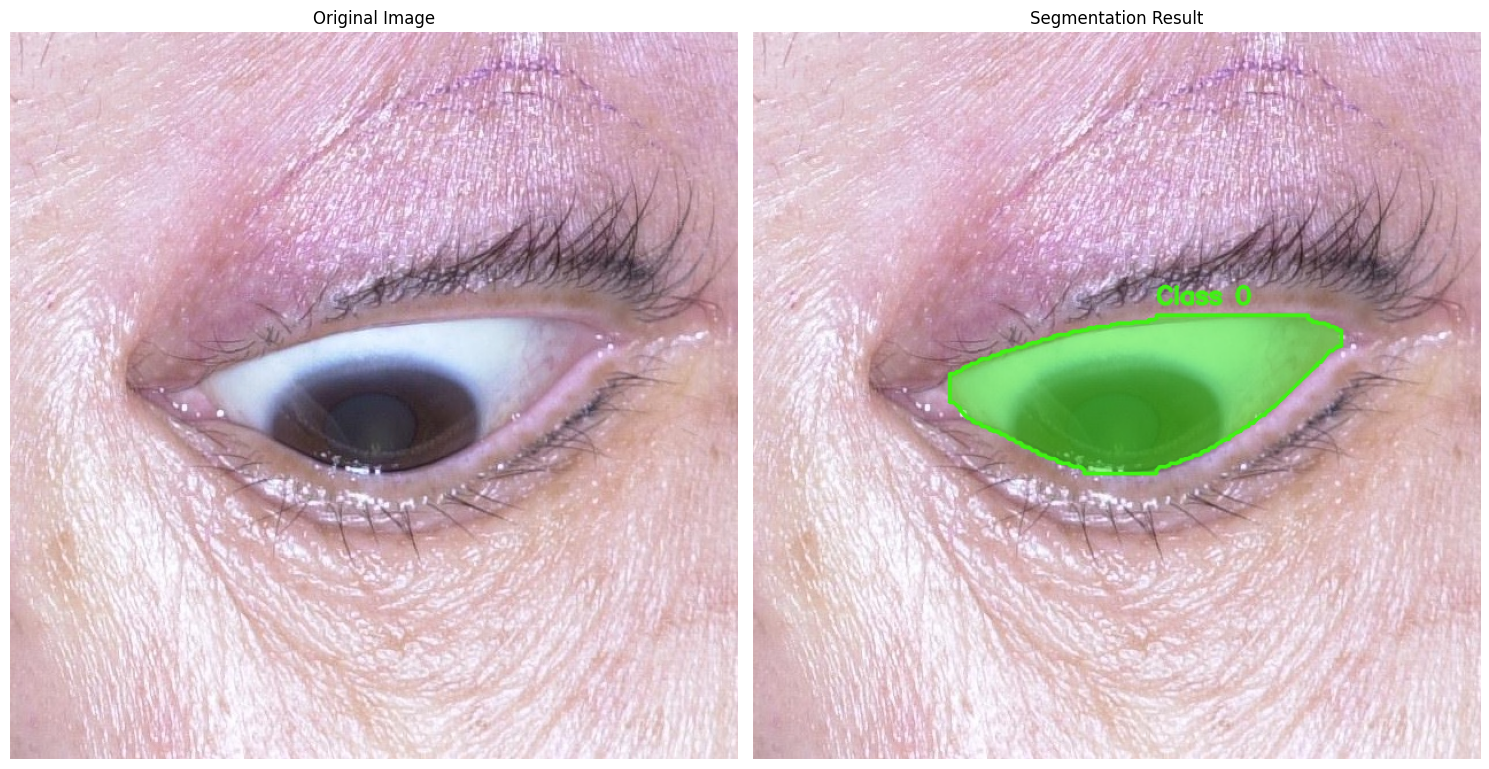

In [39]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_segmentation(image_path, label_path):
    """
    特定の画像とそれに対応するYOLOセグメンテーションラベルを読み込み、可視化する
    
    Args:
        image_path: 画像ファイルのパス
        label_path: 対応するラベルファイルのパス
    """
    # 画像を読み込む
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # ラベルファイルを読み込む
    with open(label_path, 'r') as f:
        label_lines = f.readlines()
    
    # 結果画像（元画像のコピー）
    result_image = image_rgb.copy()
    
    # 各ポリゴンに対してランダムな色を生成
    colors = []
    for _ in range(len(label_lines)):
        color = [random.randint(0, 255) for _ in range(3)]
        colors.append(color)
    
    # 各セグメンテーションのラベル行を処理
    for i, line in enumerate(label_lines):
        parts = line.strip().split()
        class_id = int(parts[0])
        
        # ポリゴン点を抽出（class_idの後の全ての値）
        polygon_points = list(map(float, parts[1:]))
        
        # x,y座標ペアに変換
        points = []
        for j in range(0, len(polygon_points), 2):
            # 座標を画像サイズに戻す（非正規化）
            x = int(polygon_points[j] * w)
            y = int(polygon_points[j+1] * h)
            points.append([x, y])
        
        # OpenCVで使用するためにnumpy配列に変換
        points = np.array(points, dtype=np.int32)
        
        # マスク画像を作成（セグメンテーション用）
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(mask, [points], 1)
        
        # 滑らかなエッジのためにぼかす
        mask = cv2.GaussianBlur(mask, (5, 5), 1.5)
        
        # マスクを[0,1]範囲の浮動小数点に変換
        mask_float = mask.astype(np.float32)
        
        # 色付きオーバーレイを作成
        colored_mask = np.zeros_like(image_rgb)
        colored_mask[:] = colors[i]
        
        # マスクを適用（浮動小数点版）
        alpha = 0.5  # 透明度
        
        # 各チャンネルに対してブレンディングを適用
        for c in range(3):
            result_image[:,:,c] = result_image[:,:,c] * (1 - alpha * mask_float) + colored_mask[:,:,c] * alpha * mask_float
        
        # アンチエイリアスを使用して輪郭線を描画
        cv2.polylines(result_image, [points], True, colors[i], 2, lineType=cv2.LINE_AA)
        
        # クラス名の表示位置（ポリゴンの一番上の点）
        top_point = points[np.argmin(points[:, 1])]
        cv2.putText(result_image, f"Class {class_id}", 
                   (top_point[0], top_point[1] - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2, lineType=cv2.LINE_AA)
    
    # 元画像とセグメンテーション結果を表示
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Segmentation Result")
    plt.imshow(result_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_random_samples(image_dir, label_dir, num_samples=3):
    """
    指定されたディレクトリからランダムにサンプル画像を選び、セグメンテーション結果を可視化する
    
    Args:
        image_dir: 画像ディレクトリのパス
        label_dir: ラベルディレクトリのパス
        num_samples: 表示するサンプル数
    """
    # 画像ファイルのリストを取得
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(image_dir, ext)))
    
    # サンプル数が画像数より多い場合は調整
    num_samples = min(num_samples, len(image_files))
    
    # ランダムにサンプルを選択
    samples = random.sample(image_files, num_samples)
    
    for image_path in samples:
        # 対応するラベルファイルのパスを取得
        basename = os.path.splitext(os.path.basename(image_path))[0]
        label_path = os.path.join(label_dir, f"{basename}.txt")
        
        # ラベルファイルが存在するか確認
        if os.path.exists(label_path):
            print(f"Processing: {basename}")
            visualize_segmentation(image_path, label_path)
        else:
            print(f"Label not found for {basename}")

def visualize_specific_image(image_dir, label_dir, image_name):
    """
    指定した特定の画像のセグメンテーション結果を可視化する
    
    Args:
        image_dir: 画像ディレクトリのパス
        label_dir: ラベルディレクトリのパス
        image_name: 画像ファイル名（拡張子付き）
    """
    # 画像パス
    image_path = os.path.join(image_dir, image_name)
    
    # 拡張子を除いたベース名を取得
    basename = os.path.splitext(os.path.basename(image_path))[0]
    
    # 対応するラベルファイルのパス
    label_path = os.path.join(label_dir, f"{basename}.txt")
    
    # ファイルの存在確認
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    if not os.path.exists(label_path):
        print(f"Label not found: {label_path}")
        return
    
    print(f"Processing: {basename}")
    visualize_segmentation(image_path, label_path)

# 使用例
if __name__ == "__main__":
    image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\segmentation_dataset\images\train"
    label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\segmentation_dataset\labels\train"
    
    # 方法1: ランダムに数枚の画像を表示
    # visualize_random_samples(image_dir, label_dir, num_samples=3)
    
    # 方法2: 特定の画像を表示（ファイル名を指定）
    visualize_specific_image(image_dir, label_dir, "2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L.jpg")